In [2]:
###### Functions for catalog matching
#
#
# MG; March 2020 - June 2021

import numpy as np
import pandas as pd
#import healpy as hp

from astroquery.simbad import Simbad
from astroquery.sdss import SDSS
from astroquery.vizier import Vizier
from astroquery.gaia import Gaia
from astropy.table import Table
from astropy.io.votable import from_table, writeto
from astropy.io import fits
from astropy_healpix import HEALPix
from astropy import units as u
from astropy.coordinates import SkyCoord, Angle, search_around_sky

import pyvo as vo

from scipy.optimize import curve_fit

from astropy.utils.exceptions import AstropyWarning
import warnings
import time

from .plot import plot1d as xplot1d
from .plot.plot1d import fixticks
from .constants import *



#-------------------------------------------------------------------------------------------
def fill_match_columns(cat, query, cat_coord, query_coord, max_sep, sep_colname, match_colname, colnames_dict,
                       query_cols=['hpidx', 'DET_LIKE_0', 'ML_FLUX_0', 'ML_CTS_0']):
    """ Service function for various matching functions

        cat - a dataframe with the user catalog which is being matched with online resource
        query - a catalog returned by astroquery (an astropy Table converted to DataFrame)
        max_sep - astropy quantity, should be same as used in astroquery query

        Firstly, match cat and query catalogs, find all pairs with separatioin <max_sep
        Then two operations are done: 

        1. For each source in cat find the closest match in query; fill columns in cat with match results.
           The following columns will be added to cat:
            columns ra_match/dec_match with the coordinates of the closest match
            column with separation which name is given by sep_colname string (e.g. sep_simb)
            boolean column whether there is a match, column name is defined by match_colname string (e.g. simb)
            columns defined by the dictionary match_dict={catcol:querycol,...}
           
        2. For each source in the query table find the nearest source in cat table and 
           add corresponding columns to the query table, characterising the cat entry and separation.
           The list of cat columns to be added to query table is specified by query_cols argument 
           + separation column + ra_x/dec_x columns

    """

    ### match cat and query catalogs, find all pairs with separatioin <max_sep
    ic,iq,sep,dist = search_around_sky(cat_coord, query_coord, max_sep)
    match=pd.DataFrame({'ic':ic, 'iq':iq, 'sep':sep.to('arcsec').value})
    
    ### for each source in cat find nearest matches in query
    idx=match.groupby(['ic']).sep.idxmin().values
    icat=match.loc[idx,'ic'].values
    iquery=match.loc[idx,'iq'].values
    sepc=match.loc[idx,'sep'].values

    cat[sep_colname]=None
    cat.iloc[icat, cat.columns.get_loc(sep_colname)]=sepc
    cat[match_colname]=False
    cat.iloc[icat,cat.columns.get_loc(match_colname)]=True
    cat['ra_match']=np.nan
    cat.iloc[icat, cat.columns.get_loc('ra_match')]=query_coord[iquery].ra.value
    cat['dec_match']=np.nan
    cat.iloc[icat, cat.columns.get_loc('dec_match')]=query_coord[iquery].dec.value
    for catcol,querycol in colnames_dict.items():
        cat[catcol]=None
        cat.iloc[icat, cat.columns.get_loc(catcol)] = query.iloc[iquery, query.columns.get_loc(querycol)].values

        
    ### for each source in query find nearest source in cat
    idx=match.groupby(['iq']).sep.idxmin().values
    icat=match.loc[idx,'ic'].values
    iquery=match.loc[idx,'iq'].values
    sepc=match.loc[idx,'sep'].values

    query['sep']=None
    query.iloc[iquery, query.columns.get_loc('sep')]=sepc
    query['ra_x']=None
    query.iloc[iquery, query.columns.get_loc('ra_x')]=cat_coord[icat].ra.value
    query['dec_x']=None
    query.iloc[iquery, query.columns.get_loc('dec_x')]=cat_coord[icat].dec.value
    for col in query_cols: 
        query[col]=None
        try:
            query.iloc[iquery, query.columns.get_loc(col)] = cat.iloc[icat, cat.columns.get_loc(col)].values
        except:
            pass
    # clean up query catalog - leave only sources having cat matches with max_sep
    # this has effect only for region based queries
    query=query.iloc[iquery].copy()

    return cat, query

#-------------------------------------------------------------------------------------------
def match_gaia(cat, match_r, ra_colname='RA', dec_colname='DEC', 
                sep_colname='sep_gaia', match_colname='gaia', 
                colnames_dict={},
                prlx_sn_min=5):
    """ Match catalog cat with GAIA
    
        A GAIA Tap job will be launched on all sources in cat.
        
        only the first nearest match within match_r is returned for each entry in cat
        match radius is match_r [arcsec]
        
        cat - pandas dataFrame
        ra_col, dec_col - str, names of the columns in cat containing RA and DEC
        
        prlx_sn_min - minimal S/N for GAIA parallax and proper motion to be called statsitically significant 

        the following columns will be added to cat:
            column with separation which name is given by sep_colname string (e.g. sep_gaia)
            boolean column whether there is a match, column name is defined by match_colname string (e.g. gaia)
            default set of coulmns + gaia_star column +
            columns defined by the dictionary colnames_dict={catcol:querycol,...}
            
        returns: catalog cat with added columns desciribing matches
                 and full result of TAP query  converted to pandas dataframe
    """

    sn_min=prlx_sn_min
    cat=cat.copy(deep=True)

    ### ra/dec of the sources
    ra,dec = cat[ra_colname].values, cat[dec_colname].values
    
    ### prepare VO table with coordinates of SRGz objects
    radec_table=Table([ra, dec], names=('RA','DEC'))
    radec_vo_table = from_table(radec_table)
    table4tap_fn="match_gaia_tmp.xml"
    writeto(radec_vo_table, table4tap_fn)

    ### launch TAP job
    match_r_degree=match_r*(1.0/3600.)
    tap_job = Gaia.launch_job_async(query=f"""
        SELECT * , distance(
            POINT('ICRS', mt.ra, mt.dec),
            POINT('ICRS', gaia.ra, gaia.dec)) AS dist
        FROM gaiaedr3.gaia_source AS gaia, tap_upload.radec_table AS mt
        WHERE 1=CONTAINS(
            POINT('ICRS', mt.ra, mt.dec),
            CIRCLE('ICRS', gaia.ra, gaia.dec, {match_r_degree}))""", 
        upload_resource=table4tap_fn, upload_table_name="radec_table", verbose=True)
    query = tap_job.get_results()

    ### prepare columns
    query['prlx_sn']=query['parallax_over_error']
    query['pmra_sn']=abs(query['pmra'])/query['pmra_error']
    query['pmdec_sn']=abs(query['pmdec'])/query['pmdec_error']
    
    colnames_dict0={'ra_gaia':'ra', 'dec_gaia':'dec'}
    gaia_cols= ['source_id',
                'phot_g_mean_mag', 'phot_g_mean_flux_over_error', 'phot_bp_mean_mag', 'phot_bp_mean_flux_over_error',
                'phot_rp_mean_mag', 'phot_rp_mean_flux_over_error',
                'parallax', 'parallax_error', 'prlx_sn', 'pmra', 'pmra_error', 'pmdec','pmdec_error','pmra_sn', 'pmdec_sn']
    for s in gaia_cols:
        colnames_dict0.update({s:s})
    colnames_dict={**colnames_dict0, **colnames_dict}
    print(colnames_dict)
    
    ### match query results with cat and fill respective columns
    query=query.to_pandas()
    query_coord=SkyCoord(query['ra'].values, query['dec'].values, frame='fk5', unit=u.degree)
    cat_coord=SkyCoord(ra, dec, frame='fk5', unit=u.degree)    
    cat,query = fill_match_columns(cat, query, cat_coord, query_coord, Angle(match_r, 'arcsec'), 
                       sep_colname, match_colname, colnames_dict)
          
    ### form gaia_star column 
    cond_star=(cat.gaia) & ((cat.prlx_sn>sn_min) | (cat.pmra_sn>sn_min) | (cat.pmdec_sn>sn_min))
    cat['gaia_star']=np.where(cond_star, True, False)
    
    ### print summary of GAIA matches
    mask_prlx=query['prlx_sn']>sn_min
    mask_pmra=query['pmra_sn']>sn_min
    mask_pmdec=query['pmdec_sn']>sn_min      
    mask_star=mask_prlx | mask_pmra | mask_pmdec
    print(f"\nSummary of GAIA matches: \
        \ninput catalog: {len(cat)} records \
        \nGAIA sources within {match_r} arcsec from X-ray source: {len(query)} \
        \nof them stars: {len(query[mask_star])} of which: \
        with parallax: {len(query[mask_prlx])}\
        with pmRA: {len(query[mask_pmra])} \
        with pmDEC: {len(query[mask_pmdec])} \
        \nX-ray sources with GAIA matches: {len(cat[cat.gaia])}\
        \nof them stars: {len(cat[cat.gaia_star])} of which: \
        with parallax: {len(cat[cat.prlx_sn>sn_min])}\
        with pmRA: {len(cat[cat.pmra_sn>sn_min])} \
        with pmDEC: {len(cat[cat.pmdec_sn>sn_min])}")
    
          
    return cat, query

#-------------------------------------------------------------------------------------------
def split_gaia_query(match_r, cat_tot, ra_colname, dec_colname, nl=100000):
    """ 
    Split a large dataframe into bits and run GAIA query for each bit
    Concatenate all outputs and return a single dataframe as a result
    """
    
    query_tot=pd.DataFrame()
    for i in range(0, len(cat_tot), nl):
        print(i,i+nl)
        cat=cat_tot.iloc[i:i+nl]
        print(len(cat),nl)
        
        ### ra/dec of the sources
        ra,dec = cat[ra_colname].values, cat[dec_colname].values
    
        ### prepare VO table with coordinates of SRGz objects
        radec_table=Table([ra, dec], names=('RA','DEC'))
        radec_vo_table = from_table(radec_table)
        table4tap_fn="match_gaia_tmp.xml"
        writeto(radec_vo_table, table4tap_fn)

        ### launch TAP job
        match_r_degree=match_r*(1.0/3600.)
        tap_job = Gaia.launch_job_async(query=f"""
            SELECT * , distance(
                POINT('ICRS', mt.ra, mt.dec),
                POINT('ICRS', gaia.ra, gaia.dec)) AS dist
            FROM gaiaedr3.gaia_source AS gaia, tap_upload.radec_table AS mt
            WHERE 1=CONTAINS(
                POINT('ICRS', mt.ra, mt.dec),
                CIRCLE('ICRS', gaia.ra, gaia.dec, {match_r_degree}))""", 
            upload_resource=table4tap_fn, upload_table_name="radec_table", verbose=True)
        query = tap_job.get_results()
        query=query.to_pandas()
        query_tot=query_tot.append(query)
    
    return query_tot
#-------------------------------------------------------------------------------------------
def match_gaia_split(cat, match_r, ra_colname='RA', dec_colname='DEC', 
                sep_colname='sep_gaia', match_colname='gaia', 
                colnames_dict={},
                prlx_sn_min=5, nl=100000):
    """ Match catalog cat with GAIA
    
        A GAIA Tap job will be launched on all sources in cat.
        using split_gaia_query (split catalog cat into chunks and run query for each chunck, then concatenate the result)

        only the first nearest match within match_r is returned for each entry in cat
        match radius is match_r [arcsec]
        
        cat - pandas dataFrame
        ra_col, dec_col - str, names of the columns in cat containing RA and DEC
        
        prlx_sn_min - minimal S/N for GAIA parallax and proper motion to be called statsitically significant 

        the following columns will be added to cat:
            column with separation which name is given by sep_colname string (e.g. sep_gaia)
            boolean column whether there is a match, column name is defined by match_colname string (e.g. gaia)
            default set of coulmns + gaia_star column +
            columns defined by the dictionary colnames_dict={catcol:querycol,...}
            
        returns: catalog cat with added columns desciribing matches
                 and full result of TAP query  converted to pandas dataframe
    """

    sn_min=prlx_sn_min
    cat=cat.copy(deep=True)
    ra,dec = cat[ra_colname].values, cat[dec_colname].values

    ### split query GAIA
    query=split_gaia_query(match_r, cat, ra_colname, dec_colname, nl=nl)

    ### prepare columns
    query['prlx_sn']=query['parallax_over_error']
    query['pmra_sn']=abs(query['pmra'])/query['pmra_error']
    query['pmdec_sn']=abs(query['pmdec'])/query['pmdec_error']
    
    colnames_dict0={'ra_gaia':'ra', 'dec_gaia':'dec'}
    gaia_cols= ['source_id',
                'phot_g_mean_mag', 'phot_g_mean_flux_over_error', 'phot_bp_mean_mag', 'phot_bp_mean_flux_over_error',
                'phot_rp_mean_mag', 'phot_rp_mean_flux_over_error',
                'parallax', 'parallax_error', 'prlx_sn', 'pmra', 'pmra_error', 'pmdec','pmdec_error','pmra_sn', 'pmdec_sn']
    for s in gaia_cols:
        colnames_dict0.update({s:s})
    colnames_dict={**colnames_dict0, **colnames_dict}
    print(colnames_dict)
    
    ### match query results with cat and fill respective columns
    query_coord=SkyCoord(query['ra'].values, query['dec'].values, frame='fk5', unit=u.degree)
    cat_coord=SkyCoord(ra, dec, frame='fk5', unit=u.degree)    
    cat,query = fill_match_columns(cat, query, cat_coord, query_coord, Angle(match_r, 'arcsec'), 
                       sep_colname, match_colname, colnames_dict)
          
    ### form gaia_star column 
    cond_star=(cat.gaia) & ((cat.prlx_sn>sn_min) | (cat.pmra_sn>sn_min) | (cat.pmdec_sn>sn_min))
    cat['gaia_star']=np.where(cond_star, True, False)
    
    ### print summary of GAIA matches
    mask_prlx=query['prlx_sn']>sn_min
    mask_pmra=query['pmra_sn']>sn_min
    mask_pmdec=query['pmdec_sn']>sn_min      
    mask_star=mask_prlx | mask_pmra | mask_pmdec
    print(f"\nSummary of GAIA matches: \
        \ninput catalog: {len(cat)} records \
        \nGAIA sources within {match_r} arcsec from X-ray source: {len(query)} \
        \nof them stars: {len(query[mask_star])} of which: \
        with parallax: {len(query[mask_prlx])}\
        with pmRA: {len(query[mask_pmra])} \
        with pmDEC: {len(query[mask_pmdec])} \
        \nX-ray sources with GAIA matches: {len(cat[cat.gaia])}\
        \nof them stars: {len(cat[cat.gaia_star])} of which: \
        with parallax: {len(cat[cat.prlx_sn>sn_min])}\
        with pmRA: {len(cat[cat.pmra_sn>sn_min])} \
        with pmDEC: {len(cat[cat.pmdec_sn>sn_min])}")
    
          
    return cat, query


ModuleNotFoundError: No module named 'astroquery'

In [2]:
from astropy.io import fits
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os 
from astropy.table import Table

In [3]:
Gm20_file = 'e:\\Observations\\Gaia_m20-result.fits'
Gm20 = Table.to_pandas(Table.read(Gm20_file, format='fits'))
nGm20 =np.array(Gm20)

C:\Users\gamak\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3343: TableReplaceWarning: converted column 'phot_bp_n_contaminated_transits' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\gamak\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3343: TableReplaceWarning: converted column 'phot_bp_n_blended_transits' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)


In [24]:
def correl_func(arr, ra, dec, tol2):
    r2 = (arr[:,5] - ra)**2 + (arr[:,7] - dec)**2
    ii = r2 <= tol2
    return ii
   

In [4]:
ra = np.empty(300000)
dec = np.empty(300000)
tol = 1
tol2 = tol*tol/3600.0/3600.0 # radius in square

In [29]:
import multiprocessing as mp

# Step 1: Init multiprocessing.Pool()
pool = mp.Pool(mp.cpu_count())

In [ ]:
pool.apply(correl_func, args = (nGm20,355.654,21.6511, tol2))

In [6]:
Gp20_file = 'e:\\Observations\\Gaia_p20-result.fits'
dat = Table.read(Gp20_file, format='fits')
Gp20 = dat.to

In [ ]:
L_file = 'e:\\Observations\\dr5_stellar.fits'
L = Table.to_pandas(Table.read(L_file, format='fits'))
nL = np.array(L)

In [4]:
nGm20=pd.DataFrame(Gm20).to_numpy()

In [5]:
nL=pd.DataFrame(L).to_numpy()

In [6]:
ra = np.empty(300000)
dec = np.empty(300000)
tol = 1
tol2 = tol*tol/3600.0/3600.0 # radius in square

In [7]:
from time import gmtime, strftime
#strftime("%H:%M:%S", gmtime())

In [1]:
strftime("%H:%M:%S", gmtime())

NameError: name 'strftime' is not defined

In [8]:
index=range(300000)
columns = ['ra','dec','class', 'subclass', 'magtype', 'mag1', 'mag2', 
           'mag3', 'mag4', 'mag5', 'mag6', 'mag7', 'teff', 'teff_err',
           'logg', 'logg_err', 'feh', 'feh_err', 'rv', 'rv_err',
           'parallax', 'parallax_error', 'phot_g_mean_mag','phot_bp_mean_mag','phot_rp_mean_mag',
           'dr2_radial_velocity', 'dr2_radial_velocity_error',
           'dr2_rv_nb_transits', 'dr2_rv_template_teff', 'dr2_rv_template_logg',
           'dr2_rv_template_fe_h', 'l', 'b']
fin_table = pd.DataFrame(index=index, columns=columns)

In [ ]:
for j in range(nL.shape[0]):
    if kk < 1000:
        i = pool.apply(correl_func, args=(nGm20,nL[j,34],nL[j,35], tol2, m)) 
        if any(i) is True:
            kk=kk+1
            for k in range(len(columns)):
                if k < 20:
                    fin_table[columns[k]][j] = L[columns[k]][np.where(i)[0][0]] 
                else:
                    fin_table[columns[k]][j] = Gm20[columns[k]][j]
        if (j/600.-np.fix(j/600.)) == 0:
            print(j,kk,strftime("%H:%M:%S", gmtime()))
    else:
        break        

In [11]:
kk = 0 
for j in range(nL.shape[0]):
    if kk < 1000:

        
        r2 = (nL[j,34] - nGm20[:,5])**2 + (nL[j,35] - nGm20[:,7])**2
        i = r2 <= tol2
        if any(i) is True:
            kk=kk+1
            for k in range(len(columns)):
                if k < 20:
                    fin_table[columns[k]][j] = L[columns[k]][np.where(i)[0][0]] 
                else:
                    fin_table[columns[k]][j] = Gm20[columns[k]][j]

def correl_func(arr, ra, dec, tol2):
    r2 = (arr[:,5] - ra)**2 + (arr[:,7] - dec)**2
    i = r2 <= tol2
    return i

        #print(kk,strftime("%H:%M:%S", gmtime()))
#            ra[k] = nL[np.where(i)[0][0],34]
#           dec[k] = nL[np.where(i)[0][0],35]
#            k=k+1
        if (j/600.-np.fix(j/600.)) == 0:
            print(j,kk,strftime("%H:%M:%S", gmtime()))
        #print('End of cycle')
    else:
        break
        

0 0 16:24:35
600 20 16:28:16
1200 38 16:31:56
1800 58 16:35:42
2400 69 16:39:25
3000 104 16:43:13
3600 146 16:47:15


KeyboardInterrupt: 

In [12]:
import multiprocessing as mp
print("Number of processors: ", mp.cpu_count())

Number of processors:  4


In [115]:
c1 = fits.Column(name='ra', array=ra, format='E')
c2 = fits.Column(name='dec', array=dec, format='E')
cols = fits.ColDefs([c1, c2])
hdu = fits.BinTableHDU.from_columns(cols)
hdu.writeto('e:\\Observations\\Coordinates.fits')

In [119]:
corel=pd.read_csv('e:\\Observations\\match_lamost_s123.csv')

In [167]:
for j in range(corel.shape[0]):
    r2 = (nL[:,34] - corel['ra'][j])**2 + (nL[:,35] - corel['dec'][j])**2
    i = r2 <= tol2
    r1 = (nGm20[:,5] - corel['ra'][j])**2 + (nGm20[:,7] - corel['dec'][j])**2
    m = r1 <= tol2    
    if any(i) is True:
        for k in range(len(columns)):
            if k < 20:
                fin_table[columns[k]][j] = L[columns[k]][np.where(i)[0][0]] 
            else:
                fin_table[columns[k]][j] = Gm20[columns[k]][np.where(m)[0][0]]
            

In [175]:
fin_table=fin_table.sort_values('teff',na_position='last')

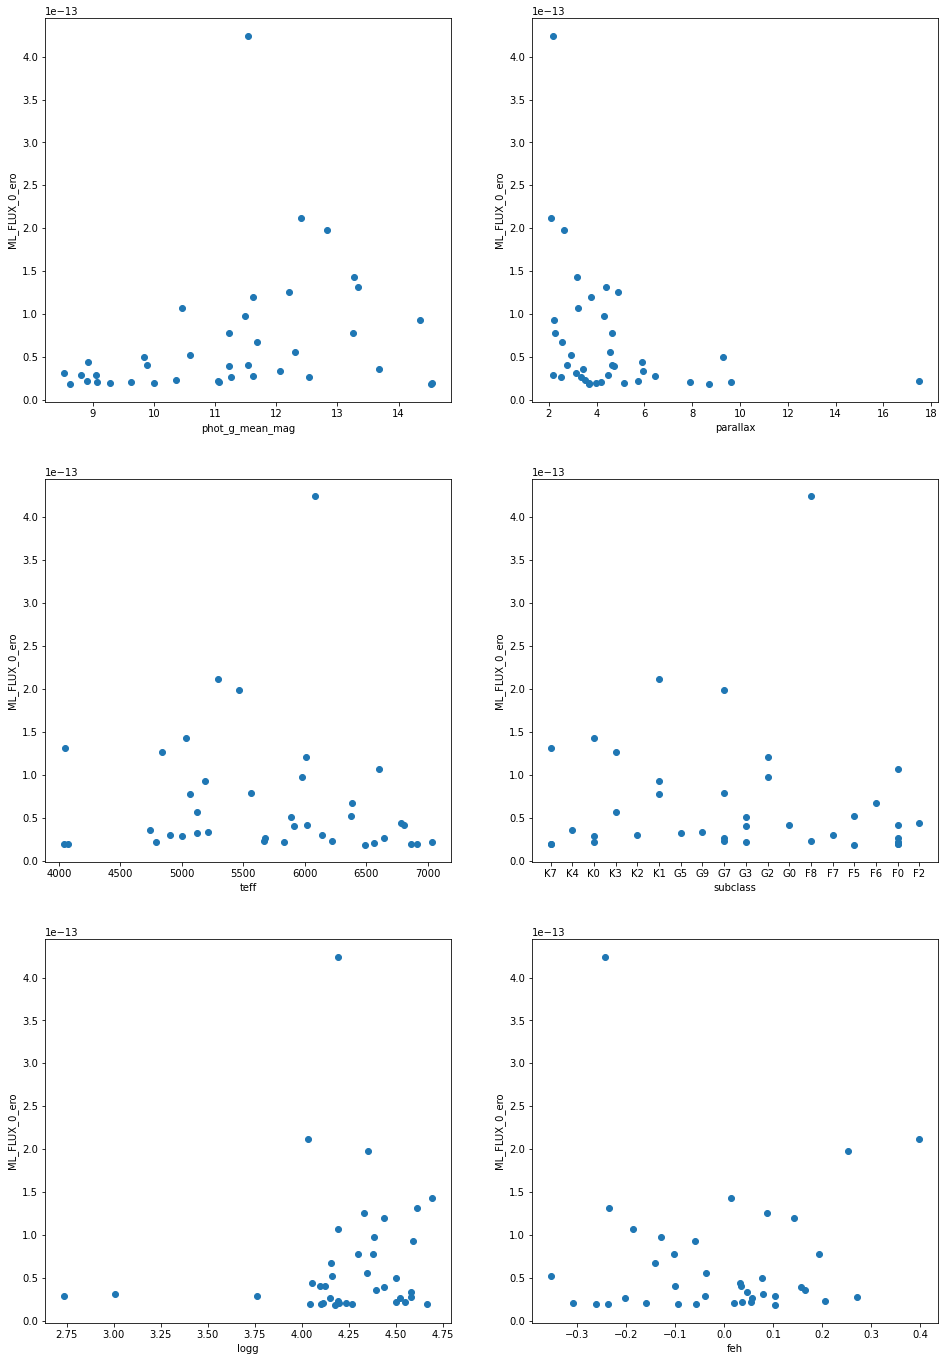

In [199]:
fig=plt.figure(figsize=(16,24))
plt.subplot(3, 2, 1)
plt.scatter(fin_table['phot_g_mean_mag'],corel['ML_FLUX_0_ero'])
plt.xlabel('phot_g_mean_mag')
plt.ylabel('ML_FLUX_0_ero')
plt.subplot(3,2,2)
plt.scatter(fin_table['parallax'],corel['ML_FLUX_0_ero'])
plt.xlabel('parallax')
plt.ylabel('ML_FLUX_0_ero')
plt.subplot(3,2,3)
plt.scatter(fin_table['teff'],corel['ML_FLUX_0_ero'])
plt.xlabel('teff')
plt.ylabel('ML_FLUX_0_ero')
plt.subplot(3,2,4)
plt.scatter(fin_table['subclass'],corel['ML_FLUX_0_ero'])
plt.xlabel('subclass')
plt.ylabel('ML_FLUX_0_ero')
plt.subplot(3,2,5)
plt.scatter(fin_table['logg'],corel['ML_FLUX_0_ero'])
plt.xlabel('logg')
plt.ylabel('ML_FLUX_0_ero')
plt.subplot(3,2,6)
plt.scatter(fin_table['feh'],corel['ML_FLUX_0_ero'])
plt.xlabel('feh')
plt.ylabel('ML_FLUX_0_ero')
plt.savefig('e:\\Observations\\figure1.pdf')

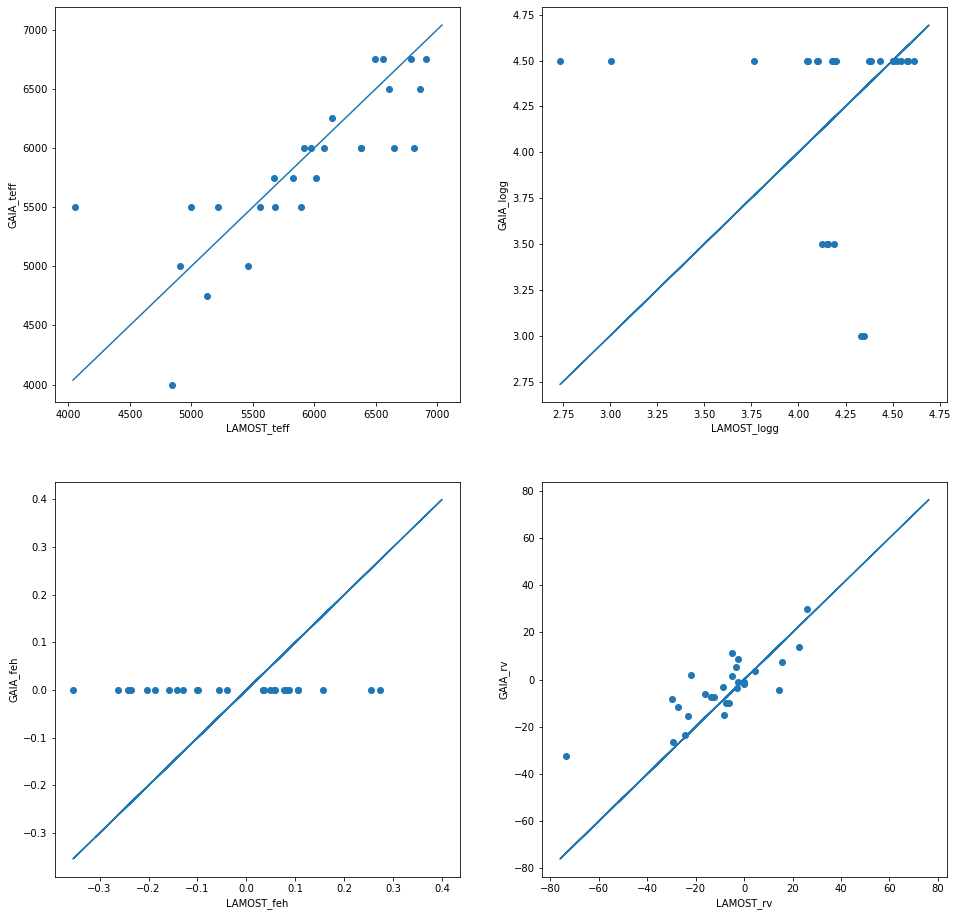

In [198]:
fig=plt.figure(figsize=(16,16))
plt.subplot(2, 2, 1)
plt.scatter(fin_table['teff'],fin_table['dr2_rv_template_teff'])
plt.plot(fin_table['teff'],fin_table['teff'])
plt.xlabel('LAMOST_teff')
plt.ylabel('GAIA_teff')
plt.subplot(2, 2, 2)
plt.scatter(fin_table['logg'],fin_table['dr2_rv_template_logg'])
plt.plot(fin_table['logg'],fin_table['logg'])
plt.xlabel('LAMOST_logg')
plt.ylabel('GAIA_logg')
plt.subplot(2, 2, 3)
plt.scatter(fin_table['feh'],fin_table['dr2_rv_template_fe_h'])
plt.plot(fin_table['feh'],fin_table['feh'])
plt.xlabel('LAMOST_feh')
plt.ylabel('GAIA_feh')
plt.subplot(2, 2, 4)
plt.scatter(fin_table['rv'],fin_table['dr2_radial_velocity'])
plt.plot(fin_table['rv'],fin_table['rv'])
plt.xlabel('LAMOST_rv')
plt.ylabel('GAIA_rv')
plt.savefig('e:\\Observations\\figure2.pdf')